In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import cv2

In [2]:
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import predict

In [3]:
config_file_path = './tracking_SAM/third_party/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
model_path = './pretrained_weights/groundingdino_swint_ogc.pth'

args = SLConfig.fromfile(config_file_path) 
device = 'cuda'

dino_model = build_model(args)

checkpoint = torch.load(model_path, map_location='cpu')
log = dino_model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
dino_model.eval()
dino_model = dino_model.to(device)

print(log)

/home/roger/anaconda3/envs/aot/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [4]:
test_img_path = "./sample_data/DAVIS_bear/images/00000.jpg"
image_np = np.asarray(Image.open(test_img_path).convert("RGB"))

transform = T.Compose(
    [
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

img_chw, _ = transform(Image.fromarray(image_np), None)

In [5]:
text_prompt = 'bear'

BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [6]:
boxes, logits, phrases = predict(
    model=dino_model, 
    image=img_chw, 
    caption=text_prompt, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device=device
)

/home/roger/anaconda3/envs/aot/lib/python3.8/site-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/roger/anaconda3/envs/aot/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [7]:
H, W, _ = image_np.shape

boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

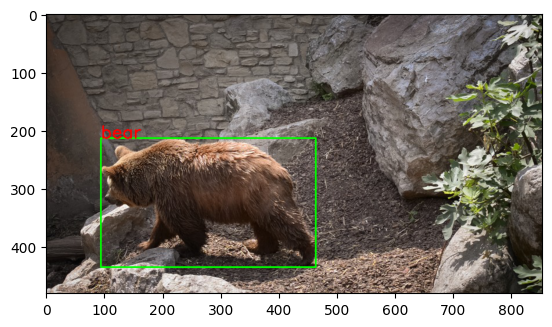

In [8]:
viz_img = image_np.copy()

for box, phrase in zip(boxes_xyxy, phrases):
    box = box.cpu().numpy().astype(np.int32)
    viz_img = cv2.rectangle(viz_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    viz_img = cv2.putText(viz_img, phrase, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

plt.imshow(viz_img)